## Question 2: Animal classification (15 marks)

For this question, we will use the Animal (https://cloudstor.aarnet.edu.au/plus/s/cZYtNAeVhWD6uBX) dataset. This dataset contains images of 151 different animals.

The dataset contains a total of 6270 images corresponding to the name of animal types.

All images are RGB images of 224 pixels wide by 224 pixels high in .jpg format. The images are separated in 151 folders according to their respective class.

The task is to categorize each animal into one of 151 categories.

We provide baseline code that includes the following features:

*   Loading and Analysing the dataset using torchvision.
*   Defining a simple convolutional neural network.
*   How to use existing loss function for the model learning.
*   Train the network on the training data.
*   Test the trained network on the testing data.

The following changes could be considered:

1. "Transfer" Learning (ie use a model pre-trained another dataset)
2. Change of advanced training parameters: Learning Rate, Optimizer, Batch-size, Number of Max Epochs, and Drop-out.
3. Use of a new loss function.
4. Data augmentation
5. Architectural Changes: Batch Normalization, Residual layers, etc.
6. Others - please ask us on the Discussion Forums if you're not sure about an idea!

Your code should be modified from the provided baseline. A pdf report of a maximum of two pages is required to explain the changes you made from the baseline, why you chose those changes, and the improvements they achieved.

### Marking Rules:

We will mark this question based on the final test accuracy on testing images and your report.

Final mark (out of 50) = acc_mark + efficiency mark + report mark

**Acc_mark 10:**

We will rank all the submission results based on their test accuracy. Zero improvement over the baseline yields 0 marks. Maximum improvement over the baseline will yield 10 marks. There will be a sliding scale applied in between.

**Efficiency mark 10:**

Efficiency considers not only the accuracy, but the computational cost of running the model (flops: https://en.wikipedia.org/wiki/FLOPS). Efficiency for our purposes is defined to be the ratio of accuracy (in %) to Gflops. Please report the computational cost for your final model and include the efficiency calculation in your report. Maximum improvement over the baseline will yield 10 marks. Zero improvement over the baseline yields zero marks, with a sliding scale in between.

**Report mark 30:**

Your report should comprise:
1. An introduction showing your understanding of the task and of the baseline model: [10 marks]

2. A description of how you have modified aspects of the system to improve performance. [10 marks]

A recommended way to present a summary of this is via an "ablation study" table, eg:

|Method1|Method2|Method3|Accuracy|
|---|---|---|---|
|N|N|N|60%|
|Y|N|N|65%|
|Y|Y|N|77%|
|Y|Y|Y|82%|

3. Explanation of the methods for reducing the computational cost and/or improve the trade-off between accuracy and cost: [5 marks]

4. Limitations/Conclusions: [5 marks]



In [1]:
##################################################################################################################################
### Subject: Computer Vision
### Year: 2024
### Student Name: Robin Viltoriano
### Student ID: a1900159
### Comptetion Name: Animal Classification Competition
### Final Results:
### ACC:         FLOPs:
##################################################################################################################################

In [2]:
# Importing libraries.

import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.notebook import tqdm
import pandas as pd

# To avoid non-essential warnings
import warnings
warnings.filterwarnings('ignore')

from torchvision import datasets, transforms, models
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

In [3]:
# # Mounting G-Drive to get your dataset.
# # To access Google Colab GPU; Go To: Edit >>> Netebook Settings >>> Hardware Accelarator: Select GPU.
# Reference: https://towardsdatascience.com/google-colab-import-and-export-datasets-eccf801e2971
from google.colab import drive
drive.mount('/content/drive')

# # Dataset path. You should change the dataset path to the location that you place the data.
data_dir = '/content/drive/MyDrive/CV/animal/dataset/dataset'
classes = os.listdir(data_dir)

Mounted at /content/drive


In [4]:
# Performing Image Transformations.
##Hints: Data Augmentation can be applied here. Have a look on RandomFlip, RandomRotation...
train_transform = transforms.Compose([
            transforms.Resize(112),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(112),
            transforms.ToTensor(),
            transforms.Normalize((0.488), (0.2172)),
        ])


In [ ]:
# Checking the dataset training size.
dataset = ImageFolder(data_dir, transform=train_transform)
print('Size of training dataset :', len(dataset))

In [ ]:
# Viewing one of images shape.
img, label = dataset[100]
print(img.shape)

In [ ]:
# Preview one of the images..
def show_image(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

In [ ]:
show_image(*dataset[100])

## Split & Preprocess Data

In [ ]:
# Setting seed so that value won't change everytime.
# Splitting the dataset to training, validation, and testing category.
torch.manual_seed(10)
val_size = len(dataset)//20
test_size = len(dataset)//10
train_size = len(dataset) - val_size - test_size

In [ ]:
# Random Splitting.
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

In [ ]:
batch_size = 16
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size, num_workers=2, pin_memory=True)

In [ ]:
# Multiple images preview.
for images, labels in train_loader:
    fig, ax = plt.subplots(figsize=(18,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
    break

# Model


In [ ]:
 # Baseline model class for training and validation purpose. Evaluation metric function - Accuracy.
def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the k top predictions for the specified values of k
    In top-3 accuracy you give yourself credit for having the right answer
    if the right answer appears in your top five guesses.
    """
    with torch.no_grad():
        maxk = 3
        batch_size = target.size(0)

        # st()
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        # st()
        # correct = pred.eq(target.view(1, -1).expand_as(pred))
        # correct = (pred == target.view(1, -1).expand_as(pred))
        correct = (pred == target.unsqueeze(dim=0)).expand_as(pred)



        correct_3 = correct[:3].reshape(-1).float().sum(0, keepdim=True)

        return correct_3.mul_(1.0 / batch_size)
#def accuracy(outputs, labels):
 #   _, preds = torch.max(outputs, dim=1)
  #  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss, Hints: the loss function can be changed to improve the accuracy
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels, (5))           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
 # To check wether Google Colab GPU has been assigned/not.

def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return None

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    # def __iter__(self):
    #     """Yield a batch of data after preprocessing and moving it to device"""
    #     for batch in self.dl:
    #         # Assuming the batch is a dictionary with 'image' and 'label' keys
    #         images = [item['image'] for item in batch]
    #         labels = [item['label'] for item in batch]
    #         # Preprocess the images using the processor
    #         inputs = self.processor(images=images, return_tensors="pt", padding=True)
    #         pixel_values = inputs['pixel_values']
    #         labels = torch.tensor(labels)
    #         # Move pixel_values and labels to the device
    #         pixel_values = to_device(pixel_values, self.device)
    #         labels = to_device(labels, self.device)
    #         yield {'pixel_values': pixel_values, 'labels': labels}

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
print(f'Device use: {device}')
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

In [ ]:
input_size = 3*112*112
output_size = 151

In [ ]:
# Convolutional Network - Baseline
class ConvolutionalNetwork(ImageClassificationBase):
    def __init__(self, classes):
        super().__init__()
        self.num_classes=classes
        self.conv1=nn.Conv2d(3,64,5,1)
        self.conv2=nn.Conv2d(64,128,3,1)
        self.conv3=nn.Conv2d(128,128,3,1)
        self.conv4=nn.Conv2d(128,128,3,1)
        self.fc1=nn.Linear(128*5*5,self.num_classes)

    def forward(self,X):
        X=F.relu(self.conv1(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv2(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv3(X))
        X=F.max_pool2d(X,2,2)
        X=F.relu(self.conv4(X))
        X=F.max_pool2d(X,2,2)
        X=X.view(-1,128*5*5)
        X=self.fc1(X)

        return F.log_softmax(X, dim=1)

In [ ]:
# Model print
num_classes = 151
model = ConvolutionalNetwork(num_classes).to(device)
print(model)

In [ ]:
# We can check the input and the output shape
for images, labels in train_loader:
    out = model(images)
    print('images.shape:', images.shape)
    print(f"{labels=}")
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

In [ ]:
train_dl = DeviceDataLoader(train_loader, device)
val_dl = DeviceDataLoader(val_loader, device)
to_device(model, device)

In [ ]:
# Functions for evaluation and training.

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(model, device)

In [ ]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 5.015639781951904, 'val_acc': 0.02187499962747097}]

In [ ]:
# Hints: The following parameters can be changed to improve the accuracy
print(test_size)
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

627


## Training Model

In [ ]:
history+= fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [0], train_loss: 3.7681, val_loss: 4.0453, val_acc: 0.2677


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1], train_loss: 3.3507, val_loss: 3.9627, val_acc: 0.2698


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2], train_loss: 3.0448, val_loss: 4.0164, val_acc: 0.2903


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3], train_loss: 2.6695, val_loss: 4.1431, val_acc: 0.3090


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4], train_loss: 2.3659, val_loss: 4.2210, val_acc: 0.3271


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5], train_loss: 2.0575, val_loss: 4.6845, val_acc: 0.3177


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6], train_loss: 1.8004, val_loss: 4.6220, val_acc: 0.3434


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7], train_loss: 1.5216, val_loss: 5.3101, val_acc: 0.3309


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8], train_loss: 1.2572, val_loss: 5.5449, val_acc: 0.3302


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9], train_loss: 1.1179, val_loss: 5.9480, val_acc: 0.3278


In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')
    plt.show()

def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    plt.show()

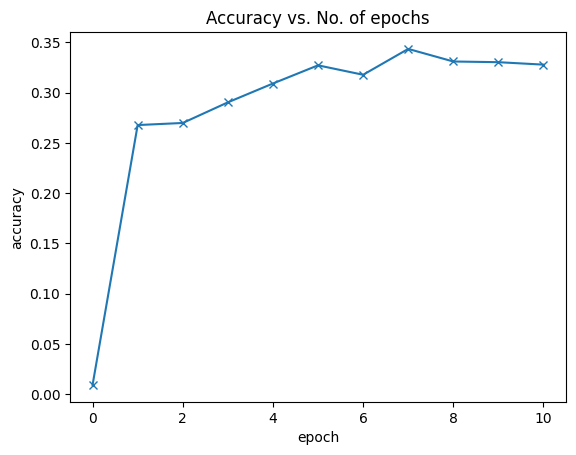

In [ ]:
plot_accuracies(history)

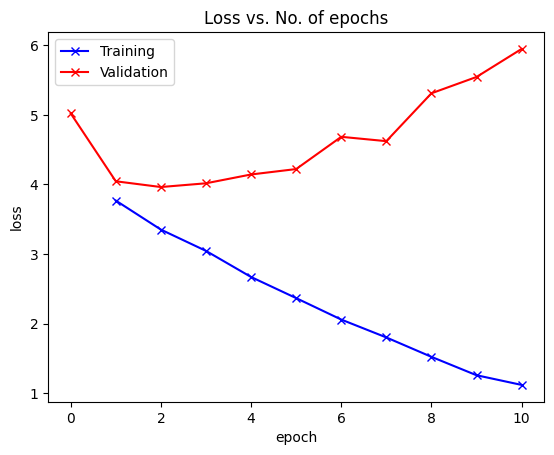

In [ ]:
plot_losses(history)

In [ ]:
model_eval = evaluate(model, test_loader)
model_eval

{'val_loss': 5.229335308074951, 'val_acc': 0.3567708432674408}

# FLOPs

In [ ]:
# !git clone https://github.com/JJBOY/FLOPs.git

In [ ]:
  # #The code from https://cloudstor.aarnet.edu.au/plus/s/PcSc67ZncTSQP0E can be used to count flops
  # #Download the code.
  # !wget -c https://cloudstor.aarnet.edu.au/plus/s/hXo1dK9SZqiEVn9/download
  # !mv download FLOPs_counter.py
  # #!rm -rf download

In [ ]:
from FLOPs.FLOPs_counter import print_model_parm_flops
input = torch.randn(1, 3, 112, 112) # The input size should be the same as the size that you put into your model
#Get the network and its FLOPs
num_classes = 151
model = ConvolutionalNetwork(num_classes)
flops = print_model_parm_flops(model, input, detail=False)

 + Number of FLOPs: 0.69G


In [ ]:
model_eff = model_eval['val_acc'] / flops
print(f'Base Model Efficiency: {model_eff:,.6f}')

Base Model Efficiency: 0.517325


In [ ]:
dict_eval = {}
dict_eval['Base Model'] = {
    'Accuracy': model_eval['val_acc'],
    'FLOPs': flops,
    'Efficiency': model_eff
}

df_evaluation = pd.DataFrame(dict_eval)
df_evaluation

,Base Model
Accuracy,0.356771
Efficiency,0.517325
FLOPs,0.689645


# Transfer Learning

## ResNet 50 from Microsoft

In [ ]:
from transformers import AutoImageProcessor, ResNetForImageClassification

processor_r50 = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model_r50 = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

In [ ]:
# Function to calculate accuracy
def accuracy_2(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

@torch.no_grad()
def evaluate_2(model, val_loader):
    model.eval()
    val_loss = 0
    val_acc = 0
    for batch in val_loader:
        images, labels = batch
        outputs = model(images).logits
        loss = F.cross_entropy(outputs, labels)
        val_loss += loss.item()
        val_acc += accuracy_2(outputs, labels).item()
    return {'val_loss': val_loss / len(val_loader), 'val_acc': val_acc / len(val_loader)}

def fit_2(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_loss = 0
        train_acc = 0
        for batch in tqdm(train_loader):
            images, labels = batch
            outputs = model(images).logits
            loss = F.cross_entropy(outputs, labels)
            train_loss += loss.item()
            train_acc += accuracy(outputs, labels).item()
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # Validation phase
        result = evaluate_2(model, val_loader)
        result['train_loss'] = train_loss / len(train_loader)
        result['train_acc'] = train_acc / len(train_loader)
        print(f"Epoch [{epoch+1}/{epochs}], train_loss: {result['train_loss']:.4f}, train_acc: {result['train_acc']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")
        history.append(result)
    return history

In [ ]:
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset

class ProcessedDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.to_pil = transforms.ToPILImage()
        self.processor.size['shortest_edge'] = 112

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        # Normalize the image
        img = self.normalize(img)
        # Convert the image to PIL format
        img = self.to_pil(img)
        # Apply processor to the image
        inputs = self.processor(images=img, return_tensors="pt")
        return inputs["pixel_values"].squeeze(0), label


# New class incorporating ResNet model
class ResNetImageClassifier(ImageClassificationBase):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet_model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")
        self.resnet_model.classifier[1] = nn.Linear(self.resnet_model.classifier[1].in_features, num_classes)

        # Freeze all layers except the last fully connected layer
        for param in self.resnet_model.parameters():
            param.requires_grad = False
        for param in self.resnet_model.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        return self.resnet_model(x).logits


In [ ]:
model_restnet_50 = ResNetImageClassifier(151)

In [ ]:
train_dataset_r50 = ProcessedDataset(train_ds, processor_r50)
val_dataset_r50 = ProcessedDataset(val_ds, processor_r50)
test_dataset_r50 = ProcessedDataset(test_ds, processor_r50)

train_loader_r50 = DataLoader(train_dataset_r50, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader_r50 = DataLoader(val_dataset_r50, batch_size=batch_size, num_workers=2, pin_memory=True)
test_loader_r50 = DataLoader(test_dataset_r50, batch_size=batch_size, num_workers=2, pin_memory=True)


In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

train_dl_r50 = DeviceDataLoader(train_loader_r50, device)
val_dl_r50 = DeviceDataLoader(val_loader_r50, device)
model_r50 = to_device(model_r50, device)

In [ ]:
history_r50=[]

In [ ]:
history_r50 += fit_2(num_epochs, lr, model_r50, train_dl_r50, val_dl_r50, opt_func)

  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [1/10], train_loss: 4.9969, train_acc: 0.0438, val_loss: 4.8761, val_acc: 0.0187


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [2/10], train_loss: 4.6924, train_acc: 0.1044, val_loss: 4.8542, val_acc: 0.0181


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [3/10], train_loss: 4.5350, train_acc: 0.1443, val_loss: 4.8779, val_acc: 0.0156


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [4/10], train_loss: 4.4187, train_acc: 0.1729, val_loss: 4.8316, val_acc: 0.0368


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [5/10], train_loss: 4.3007, train_acc: 0.2073, val_loss: 4.9407, val_acc: 0.0212


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [6/10], train_loss: 4.2145, train_acc: 0.2264, val_loss: 4.8463, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [7/10], train_loss: 4.1237, train_acc: 0.2530, val_loss: 4.8448, val_acc: 0.0219


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [8/10], train_loss: 4.0673, train_acc: 0.2618, val_loss: 5.0105, val_acc: 0.0063


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [9/10], train_loss: 4.0043, train_acc: 0.2764, val_loss: 4.8082, val_acc: 0.0281


  0%|          | 0/334 [00:00<?, ?it/s]

Epoch [10/10], train_loss: 3.9264, train_acc: 0.2987, val_loss: 4.8175, val_acc: 0.0361


In [ ]:
from torch.optim import AdamW

optimizer = AdamW(model_r50.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

num_epochs = 2

for epoch in range(num_epochs):
    model_r50.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images_raw, labels = batch

        optimizer.zero_grad()

        outputs = model_r50(images)
        loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)
    print(f"Epoch {epoch + 1}/{num_epochs}, Average Loss: {avg_loss:.4f}")

Epoch 1/2:   0%|          | 0/334 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_dl, desc="Evaluating"):
        images, labels = batch
        images = images.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

Evaluating:   0%|          | 0/20 [00:00<?, ?it/s]

Validation Accuracy: 0.7764


## ViT

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
import requests


processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits
# model predicts one of the 1000 ImageNet classes
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])
